In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from pymongo import MongoClient
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
client = MongoClient(os.environ["ECOMMERCE__CONNECTION_STRING"])
db = client["ecommerce"]
serverStatusResult = db.command("serverStatus")
pprint(serverStatusResult)

/toolkit-cache/0.2.0/python3.9/kernel-libs/lib/python3.9/site-packages/pymongo/ocsp_support.py:280: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to this_update_utc.
  if response.this_update > now:
/toolkit-cache/0.2.0/python3.9/kernel-libs/lib/python3.9/site-packages/pymongo/ocsp_support.py:284: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to next_update_utc.
  if response.next_update and response.next_update < now:
/toolkit-cache/0.2.0/python3.9/kernel-libs/lib/python3.9/site-packages/pymongo/ocsp_cache.py:65: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to next_update_utc.
  if value.next_update is None:
/toolkit-cache/0.2.0/python3.9/kernel-libs/lib/python3.9/site-packages/pymongo/ocsp_cache.py:71: CryptographyDeprecationWarning: Properties that return a naïve datetime object

In [3]:
collections = db.list_collection_names()
print("Available collections:",collections)



Available collections: ['Expense-IIGF', 'International-Sale-Report', 'Sales-March-2021-Cleaned', 'Sales-May-2022', 'International-Sale-Report-Cleaned', 'Cloud-Warehouse-Compersion-Chart', 'Amazon-Sale-Report', 'Sales-May-2022-Cleaned', 'Sales-Report-Cleaned', 'Amazon-Sale-Report-Cleaned', 'Sales-March-2021', 'Sales-Report']


In [4]:
# Convert MongoDB data to Pandas DataFrame
sales_report = db['International-Sale-Report'].find()
df = pd.DataFrame(list(sales_report))
print(df.columns)

Index(['_id', 'index', 'DATE', 'Months', 'CUSTOMER', 'Style', 'SKU', 'Size',
       'PCS', 'RATE', 'GROSS AMT'],
      dtype='object')


In [5]:
df.head(4)

,_id,index,DATE,Months,CUSTOMER,Style,SKU,Size,PCS,RATE,GROSS AMT
0,672d28fe5b46a7edd82c97e1,0,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-L,L,1.00,616.56,617.00
1,672d28fe5b46a7edd82c97e2,1,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XL,XL,1.00,616.56,617.00
2,672d28fe5b46a7edd82c97e3,2,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XXL,XXL,1.00,616.56,617.00
3,672d28fe5b46a7edd82c97e4,3,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5009,MEN5009-KR-L,L,1.00,616.56,617.00


/tmp/ipykernel_363/1496082131.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
/tmp/ipykernel_363/1496082131.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Year'] = df['DATE'].dt.year
/tmp/ipykernel_363/1496082131.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Month'] = df['DATE'].dt.month
/tm

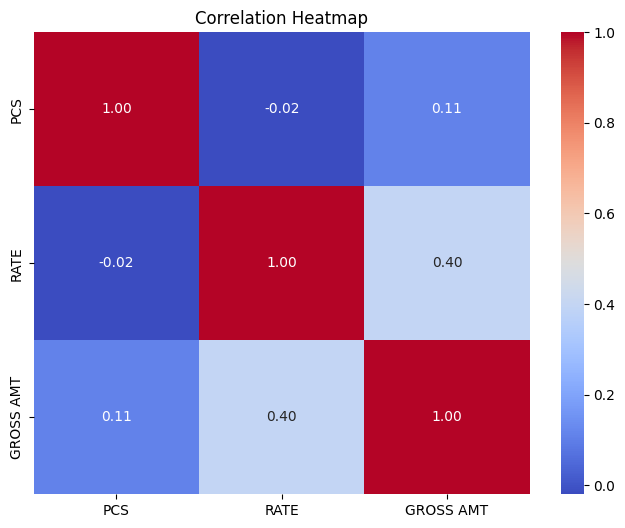

In [6]:
df = df.dropna()
# Convert date to datetime 
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

df['RATE'] = pd.to_numeric(df['RATE'], errors='coerce')

# Drop rows where RATE could not be converted (NaN after coercion)
df = df.dropna(subset=['RATE'])

df = df[df['DATE'].notnull()]
X = df[['DATE', 'Months', 'CUSTOMER', 'Style', 'SKU', 'Size', 'PCS', 'RATE']]
y = df['GROSS AMT']


#df['DATE'] = pd.to_datetime(df['DATE'])
X['Year'] = df['DATE'].dt.year
X['Month'] = df['DATE'].dt.month
X.drop(columns=['DATE'], inplace=True)

numerical_cols = ['PCS', 'RATE', 'GROSS AMT']  # Include relevant numerical columns
correlation_matrix = df[numerical_cols].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Remove highly correlated variables
correlation_threshold = 0.8
high_corr_pairs = [(i, j) for i in correlation_matrix.columns for j in correlation_matrix.columns
                   if i != j and abs(correlation_matrix.loc[i, j]) > correlation_threshold]

# Variables to drop
to_drop = set()
for i, j in high_corr_pairs:
    to_drop.add(j)  # Add one of the highly correlated variables to drop

# Drop highly correlated variables
X = X.drop(columns=list(to_drop), errors='ignore')


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['PCS', 'RATE', 'Year', 'Month']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Months', 'CUSTOMER', 'Style', 'SKU', 'Size'])
])

# Model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 15007345.84575181
R^2 Score: 0.24596146946651654


In [8]:
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 533.2811783804739


In [9]:
df['GROSS AMT'].unique()

array(['617.00', '20000', '649.00', '324.00', '422.00', '389.00',
       '584.00', '454.00', '519.00', '487.00', '531.00', '357.00',
       '747.00', '1072.00', '1429.00', '1494.00', '1202.00', '50000',
       '552.00', '942.00', '292.00', '-500', '1169.00', '1104.00',
       '812.00', '779.00', '1137.00', '844.00', '1299.00', '1364.00',
       '1039.00', '909.00', '1234.00', '877.00', '714.00', '1298.00',
       '974.00', '574.00', '583.00', '994.00', '500.00', '619.00',
       '2717.00', '2898.00', '2535.00', '3261.00', '2416.00', '2778.00',
       '4108.00', '3625.00', '2173.00', '3079.00', '2899.00', '3141.00',
       '3383.00', '3262.00', '5075.00', '4834.00', '4350.00', '5559.00',
       '1948.00', '1558.00', '1461.00', '0', '3118.00', '2079.00',
       '3313.00', '4483.00', '2989.00', '2241.00', '1754.00', '3508.00',
       '2339.00', '1689.00', '1624.00', '3245.00', '9735.00', '3894.00',
       '4543.00', '580.00', '1160.00', '1220.00', '1830.00', '1649.00',
       '824.00', '1

In [10]:
y_test


7925      425.00
12730     850.00
7509      463.00
980       406.00
12378    1017.00
          ...   
4516     1572.00
3663      393.00
2029     4034.00
8098      439.00
7084      558.00
Name: GROSS AMT, Length: 3444, dtype: object

In [11]:
y_test = pd.to_numeric(y_test, errors='coerce')
valid_indices = ~y_test.isna()
y_test = y_test[valid_indices]
y_pred = y_pred[valid_indices]

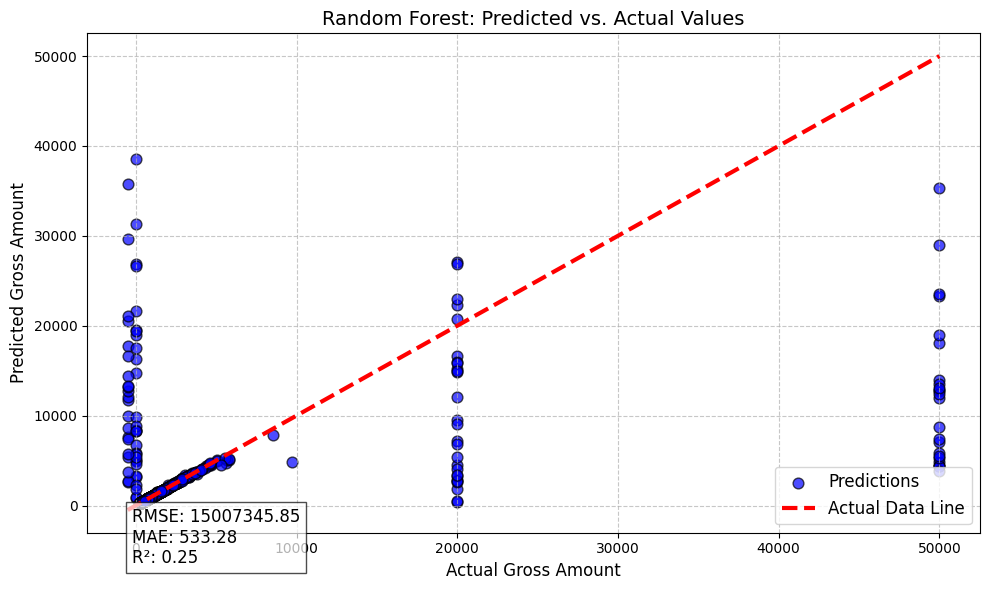

In [18]:
# Plot Predicted vs Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', edgecolors='black', label='Predictions', s=60)

# The line where predicted values = actual values (Perfect prediction line)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=3, linestyle='--', label='Actual Data Line')

# Labels and Title
plt.xlabel('Actual Gross Amount', fontsize=12)
plt.ylabel('Predicted Gross Amount', fontsize=12)
plt.title('Random Forest: Predicted vs. Actual Values', fontsize=14)

# Add evaluation metrics on the plot (adjusted location)
plt.text(0.05, 0.05, f'RMSE: {mse:.2f}\nMAE: {mae:.2f}\nR²: {r2:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Display legend in the bottom-right corner
plt.legend(fontsize=12, loc='lower right')

# Improve grid visibility
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


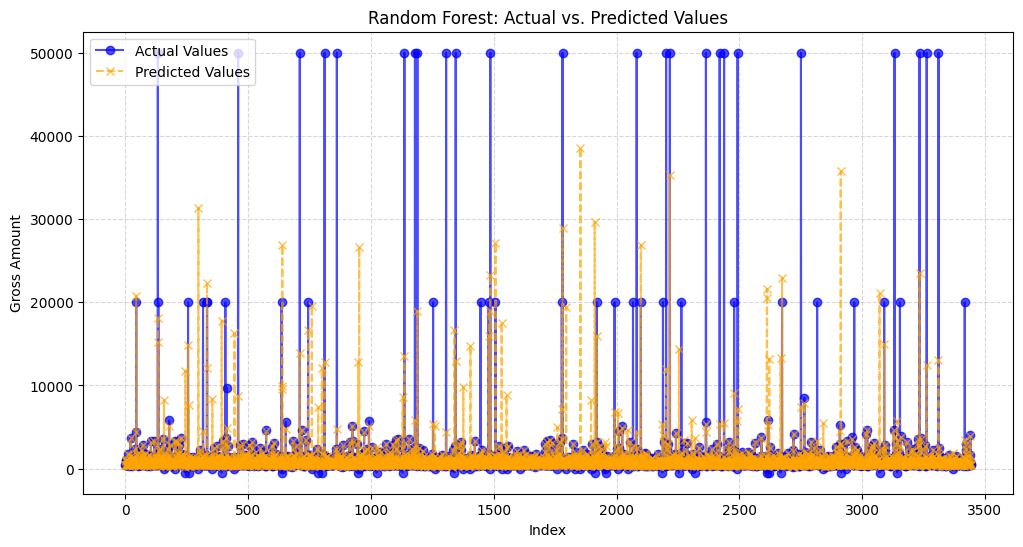

In [18]:
# Plot Actual and Predicted Values Separately
plt.figure(figsize=(12, 6))

# Plot Actual Values
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue', marker='o', linestyle='-', alpha=0.7)

# Plot Predicted Values
plt.plot(range(len(y_pred)), y_pred, label='Predicted Values', color='orange', marker='x', linestyle='--', alpha=0.7)

# Formatting the plot
plt.xlabel('Index')
plt.ylabel('Gross Amount')
plt.title('Random Forest: Actual vs. Predicted Values')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e322a799-a681-4754-b873-85c47d774f17' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>